<a href="https://colab.research.google.com/github/rajarathnambalakrishnan/Image-Recognition-for-Autonomous-Driving/blob/master/Classifier_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifier Training**

###1. This notebook contains codes that were used to build the two classifiers DenseNet and ResNet. 

###2. Contains the codes to download and prepare tfds dataset

###3. Contains codes to compile and train the classifiers

## Dataset loading

In [0]:
# dependencies...
try:
  %tensorflow_version 2.x
except Exception:
  pass

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

%matplotlib inline
import urllib3
urllib3.disable_warnings()

import PIL.Image
import tensorflow_addons as tfa

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# downloading the data


(raw_train, raw_val, raw_test), metadata = tfds.load(name='cifar10',
                                                     with_info = True,
                                                     split = ['train[:80%]', 'train[80%:]', 'test'],
                                                     as_supervised = True)


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incompleteVP5EHJ/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incompleteVP5EHJ/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.0. Subsequent calls will reuse this data.


In [0]:
print(raw_train)
print(raw_val)
print(raw_test)

<DatasetV1Adapter shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>


In [0]:
print(metadata)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.0,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [0]:
# image preprocessing such as int to floating values, augmentation

def preprocess(image,label):

  image = tf.cast(image,tf.float32)
  image = image/255.0
  return image,label


def augment(image,label):

  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_contrast(image, lower = 0.0, upper = 1.0)
  image = tf.image.random_brightness(image, max_delta = 0.2)
  return image,label


In [0]:
train = raw_train.map(preprocess)
train = train.map(augment)
val = raw_val.map(preprocess)
test = raw_test.map(preprocess)

In [0]:
# setting batch size and suffle option to the training data

train = train.shuffle(2048)
train = train.batch(64)
val = val.batch(64)
test = test.batch(64)

train = train.prefetch(tf.data.experimental.AUTOTUNE)


In [0]:
# visualizing the dataset 
label = metadata.features['label'].int2str

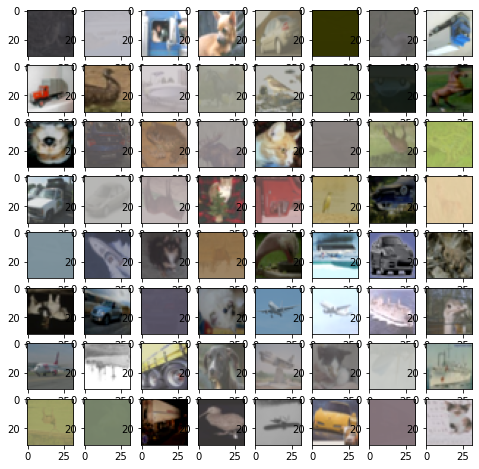

In [0]:
plt.figure(figsize = (8,8))

for batch in train.take(1):
  for i in range(64):
    image, label = batch[0][i], batch[1][i]
    plt.subplot(8,8,i+1)
    plt.imshow(image.numpy())
    #plt.title(label)
    plt.grid(False)

In [0]:

from tensorflow import keras
from tensorflow.python.keras import backend
from tensorflow.python.keras.engine import training
from tensorflow.keras import Input, Model,utils, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Activation, Concatenate, AvgPool2D, GlobalAvgPool2D, Dense, Add, Dropout

## DenseNet Build

In [0]:
NUM_CLASSES = 10
IMG_SHAPE = (32,32,3)

In [0]:
def dense_block(x, block_length ,depth):
  '''
  Arguments: 
  input: input tensor
  block_length: length of block 
  depth: number of channels for each conv layer in the block

  '''

  for i in range(block_length):
    x = conv_block(x, depth)
  return x

def conv_block(x, depth):

  '''
  Arguments: 
  input: input tensor 
  depth: number of channels for each conv layer in the block

  '''

  x1 = BatchNormalization(axis=-1)(x)
  x1 = Activation('relu')(x1)
  x1 = Conv2D(depth, 3, padding='same')(x1)
  x = Concatenate(axis=-1)([x,x1])
  return x



def transition_block(x):

  x = BatchNormalization(axis=-1)(x)
  x = Conv2D(int(backend.int_shape(x)[3]), (1,1))(x)
  x = AvgPool2D((2,2), strides=2)(x)

  return x


def build_densenet():


  img_input = Input(shape = IMG_SHAPE)
  x = Conv2D(64, (7,7), (2,2), padding='same')(img_input)
  x = BatchNormalization(axis=-1)(x)
  x = Activation('relu')(x)
  x = MaxPool2D((3,3), (2,2), padding='same')(x)

  x = dense_block(x, 4, 32) # DenseBlock1
  x = transition_block(x) # TransitionBlock1

  x = dense_block(x,4,32) # DenseBlock2
  x = transition_block(x) #TransitionBlock2

  x = dense_block(x,4,32) # DenseBlock3
  x = transition_block(x) #TransitionBlock3

  x = dense_block(x,4,32) # DenseBlock4

  x = BatchNormalization(axis=-1)(x)
  x = GlobalAvgPool2D()(x)
  x = Dense(metadata.features['label'].num_classes, activation='softmax')(x)


  model = Model(img_input, x, name='densenet')
  return model

In [0]:
model = build_densenet()

In [0]:
model.summary()

Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [0]:
tf.keras.utils.plot_model(model,'densenet_classifier.png', show_shapes=True)

## ResNet Build

In [0]:
def res_block(input_set, filters):
  x = Conv2D(filters, 3, activation='relu', padding='same', use_bias = False)(input_set)
  x = BatchNormalization()(x)
  x = Conv2D(filters, 3, activation=None, padding='same', use_bias = False)(x)
  x = BatchNormalization()(x)
  x = Add()([x, input_set])
  x = Activation('relu')(x)
  return x

def build_resnet():
  img_input = Input((32,32,3),dtype='float32')
  x = Conv2D(64, 3, activation='relu')(img_input)
  x = BatchNormalization()(x)
  x = MaxPool2D(3)(x)
  old = 64
  for i in range(16):
    x = res_block(x, 64)


  x = Conv2D(64, 3, activation='relu')(x)
  x = GlobalAvgPool2D()(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(10, activation='softmax')(x)

  model = Model(img_input, x, name='ResNet-34')

  return model

In [0]:
model = build_resnet()

In [0]:
model.summary()

Model: "ResNet-34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 30, 30, 64)   1792        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_119 (BatchN (None, 30, 30, 64)   256         conv2d_122[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 10, 10, 64)   0           batch_normalization_119[0][0]    
__________________________________________________________________________________________

## Training the classifier

In [0]:
num_train = metadata.splits['train'].num_examples * 0.8
num_val = metadata.splits['train'].num_examples * 0.2
num_test = metadata.splits['test'].num_examples

print('Number of training examples: ',num_train)
print('Number of validation examples: ',num_val)
print('Number of testing examples: ',num_test)

steps_per_epoch = round(num_train)//64
validation_steps = round(num_val)//64

Number of training examples:  40000.0
Number of validation examples:  10000.0
Number of testing examples:  10000


# Training 

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
def train_model(model):

  #model = build_densenet() # DENSENET MODEL
  model = build_resnet() # RESNET MODEL 
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  # create callbacks
  model_checkpoing_callback = ModelCheckpoint('training_checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5', period = 5)
  os.makedirs('training_checkpoints/', exist_ok=True)
  early_stopping_checkpoint = EarlyStopping(patience=5)

  

  history = model.fit(train.repeat(),
                      epochs = 30,
                      steps_per_epoch = steps_per_epoch,
                      validation_data = val.repeat(),
                      validation_steps = validation_steps,
                      callbacks = [model_checkpoing_callback,
                                   early_stopping_checkpoint])
  
  return history

In [0]:
t_acc = []
t_val_acc = []
t_loss = []
t_val_loss = []

In [0]:
history = train_model(model) 

In [0]:
t_acc += history.history['accuracy']
t_val_acc += history.history['val_accuracy']

t_loss += history.history['loss']
t_val_loss += history.history['val_loss']

In [0]:
model.load_weights('training_checkpoints/weights.40-0.78.hdf5')
model.evaluate(test)